In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

In [2]:
%%bash
ls data

Outcomes-a.txt
PhysioNet_Computing in_Cardiology_Challenge_2012.pdf
Reference.txt
seta_data.csv


## Exploratory Data Analysis

Questions:

- What is the more common outcome? Survival or death?
- What are the general ranges of each field?
- Which fields are most predictive of the outcome?
- When does missingness happen?
- Does missingness tell us inform us about the probability of survival? Or is it missing completely at random?
- Is there a subtype of people that the model is doing poorly on? Is there something in common among people that are mislabeled?
- Does the length of time tell us something about the measurements tell us something about survival?
- Should we see the times?
- What are the "normal" ranges for variable, given the literature? How much does an individual stay in (or outside) the "normal" range? given the 48 hours???



### load data

In [3]:
seta_data = pd.read_csv('data/seta_data.csv')
seta_data.head(5)

,PATIENT_ID,Parameter,Time,Value
0,132539,RecordID,00:00,132539.0
1,132539,Age,00:00,54.0
2,132539,Gender,00:00,0.0
3,132539,Height,00:00,-1.0
4,132539,ICUType,00:00,4.0


In [4]:
# seta_data.index = seta_data.PATIENT_ID

In [5]:
outcomes = pd.read_csv('data/Outcomes-a.txt')

In [6]:
outcomes.head(5)

,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,6,1,5,-1,0
1,132540,16,8,8,-1,0
2,132541,21,11,19,-1,0
3,132543,7,1,9,575,0
4,132545,17,2,4,918,0


### number of survivals

In [7]:
num_survivals = outcomes.groupby('In-hospital_death').count()['Survival']

In [8]:
num_survivals

In-hospital_death
0    3446
1     554
Name: Survival, dtype: int64

In [9]:
in_hospital_death_outcomes = outcomes[outcomes['In-hospital_death'] == 1]
not_in_hospital_death_outcomes = outcomes[outcomes['In-hospital_death'] == 0]

In [10]:
print(str(num_survivals[0] / (num_survivals[0] + num_survivals[1])) + ' of the sample survive.')

0.8615 of the sample survive.


In [30]:
seta_data.columns

Index(['PATIENT_ID', 'Parameter', 'Time', 'Value', 'Time_delta', 'time_block'], dtype='object')

In [32]:
unique_patient_ids = seta_data['PATIENT_ID'].unique()
unique_patient_ids.shape

(4000,)

We could compare the values of those who did survive vs those who didn't survive, for each category. See if there are any patterns.

When there's a "-1", maybe we could just skip it?

Prior knowledge: 

1. People are more likely to die if their measurements are too high or too low (i.e. not normal).
2. Huge variability of measurements within an individual could indicate severity of a problem. Severity obviously influences mortality.
3. Where they end up affects the types of measurements that are collected, which might give us information about severity.

We could maybe find the optimal number of samples. Then we could take the average (or some statistic) of that certain section so we have a standardized data set.

In [12]:
{
    'HR': [60, 100] # https://www.mayoclinic.org/healthy-lifestyle/fitness/expert-answers/heart-rate/faq-20057979
    
}

{'HR': [60, 100]}

In [13]:
unique_parameters = seta_data['Parameter'].unique()
params_without_record_id = list(set(unique_parameters) - set(['RecordID']))

In [14]:
in_hospital_death_data = seta_data[seta_data.index.isin(in_hospital_death_outcomes['RecordID'])]
not_in_hospital_death_data = seta_data[seta_data.index.isin(not_in_hospital_death_outcomes['RecordID'])]

### set time string to timedelta

In [15]:
seta_data['Time_delta'] = pd.to_timedelta(seta_data['Time'] + ':00', 'hours')
seta_data['Time_delta'].tail(5)

1757975   1 days 23:36:00
1757976   1 days 23:36:00
1757977   1 days 23:36:00
1757978   1 days 23:36:00
1757979   1 days 23:36:00
Name: Time_delta, dtype: timedelta64[ns]

### Discretize Time into 3-hour blocks

Why 3 hours? Well, there are 16 3-hour blocks in 48 hours. 16 * 40 variables is 640, which is less than 4000, so $n$ > $p$. $n$ < $p$ is a bad place to be, as we can have an infinite number of solutions.

In [16]:
def bin_time(df, width_hours=3, num_hours=48, timedelta_col='Time_delta'):
    for i in range(int(num_hours / width_hours)):
        start = i * width_hours
        end = start + width_hours
        start_string = str(start) + ' hours'
        end_string = str(end) + ' hours'
        
        start_timedelta = pd.to_timedelta(start_string)
        end_timedelta = pd.to_timedelta(end_string)
        
        mask = (df[timedelta_col] >= start_timedelta) & (df[timedelta_col] < end_timedelta)
        
        df.loc[mask, 'time_block'] = start

In [17]:
bin_time(seta_data)

In [18]:
seta_data

,PATIENT_ID,Parameter,Time,Value,Time_delta,time_block
0,132539,RecordID,00:00,132539.00,0 days 00:00:00,0.0
1,132539,Age,00:00,54.00,0 days 00:00:00,0.0
2,132539,Gender,00:00,0.00,0 days 00:00:00,0.0
3,132539,Height,00:00,-1.00,0 days 00:00:00,0.0
4,132539,ICUType,00:00,4.00,0 days 00:00:00,0.0
5,132539,Weight,00:00,-1.00,0 days 00:00:00,0.0
6,132539,GCS,00:07,15.00,0 days 00:07:00,0.0
7,132539,HR,00:07,73.00,0 days 00:07:00,0.0
8,132539,NIDiasABP,00:07,65.00,0 days 00:07:00,0.0
9,132539,NIMAP,00:07,92.33,0 days 00:07:00,0.0


### plot data

In [19]:
def plot(parameter, data, ax):
    for patient_id in data.index.unique():
        patient = data.loc[patient_id]
        param = patient['Parameter'] == parameter
        if param.sum() > 0:
            # patient[param ]
            patient[param].plot(x='Time', y='Value', ax=ax, alpha=0.3, legend=False)

### Convert -1 to NaN

Convert -1 to None so when we take aggregates, we don't make it seem that missing is basically almost the same as 0.

In [20]:
seta_data.replace(to_replace=-1, value=np.NaN, inplace=True)

In [21]:
averaged = seta_data.groupby(['PATIENT_ID', 'Parameter', 'time_block']).mean()

In [22]:
reset_averaged = averaged.reset_index()

In [23]:
reset_averaged

,PATIENT_ID,Parameter,time_block,Value
0,132539,Age,0.0,54.000000
1,132539,BUN,9.0,13.000000
2,132539,BUN,33.0,8.000000
3,132539,Creatinine,9.0,0.800000
4,132539,Creatinine,33.0,0.700000
5,132539,GCS,0.0,15.000000
6,132539,GCS,3.0,15.000000
7,132539,GCS,6.0,15.000000
8,132539,GCS,9.0,15.000000
9,132539,GCS,15.0,15.000000


In [24]:
standardizable_vars = list(set(params_without_record_id) - set([
    'ICUType', # categorical
    'Gender',  # dichotomous,
    'MechVent', # useless; same value across all individuals
]))
standardizable_vars

['Age',
 'TroponinI',
 'ALT',
 'FiO2',
 'GCS',
 'NISysABP',
 'Glucose',
 'NIDiasABP',
 'pH',
 'SaO2',
 'K',
 'HCT',
 'Lactate',
 'Bilirubin',
 'AST',
 'Platelets',
 'NIMAP',
 'PaCO2',
 'HCO3',
 'HR',
 'Height',
 'ALP',
 'SysABP',
 'BUN',
 'Mg',
 'RespRate',
 'Cholesterol',
 'Temp',
 'Na',
 'Creatinine',
 'PaO2',
 'MAP',
 'WBC',
 'TroponinT',
 'Weight',
 'Urine',
 'DiasABP',
 'Albumin']

In [34]:
unique_patient_ids.shape

(4000,)

### Create cross-product

In [38]:
index = pd.MultiIndex.from_product(
    [unique_patient_ids, standardizable_vars, list(range(0, 48, 3))], 
    names = ["PATIENT_ID", "Parameter", "time_block"]
)

cross_product = pd.DataFrame(index = index).reset_index()
cross_product['Value'] = np.nan

### Merge

In [42]:
merged = pd.merge(left=cross_product, right=reset_averaged, on=['PATIENT_ID', 'Parameter', 'time_block'], how='left')
merged

,PATIENT_ID,Parameter,time_block,Value_x,Value_y
0,132539,Age,0,NaN,54.000000
1,132539,Age,3,NaN,NaN
2,132539,Age,6,NaN,NaN
3,132539,Age,9,NaN,NaN
4,132539,Age,12,NaN,NaN
5,132539,Age,15,NaN,NaN
6,132539,Age,18,NaN,NaN
7,132539,Age,21,NaN,NaN
8,132539,Age,24,NaN,NaN
9,132539,Age,27,NaN,NaN


In [44]:
for param in standardizable_vars:
    merged.loc[
        (merged['Parameter'] == param) & (merged['Value_y'].isnull()),
        'Value_y'
    ] = seta_data[seta_data['Parameter'] == param]['Value'].mean()

In [51]:
merged['Parameter_3_hour_block'] = merged['Parameter'] + '_' + (merged['time_block']).astype('str')
merged

,PATIENT_ID,Parameter,time_block,Value_x,Value_y,Parameter_3_hour_block
0,132539,Age,0,NaN,54.000000,Age_0
1,132539,Age,3,NaN,64.247500,Age_3
2,132539,Age,6,NaN,64.247500,Age_6
3,132539,Age,9,NaN,64.247500,Age_9
4,132539,Age,12,NaN,64.247500,Age_12
5,132539,Age,15,NaN,64.247500,Age_15
6,132539,Age,18,NaN,64.247500,Age_18
7,132539,Age,21,NaN,64.247500,Age_21
8,132539,Age,24,NaN,64.247500,Age_24
9,132539,Age,27,NaN,64.247500,Age_27


In [57]:
def get_predictors(
    df, 
    parameter_time_block_column='Parameter_3_hour_block', 
    value_column='Value_y', 
    patient_id_col='PATIENT_ID'
):
    unique_param_time_blocks = df[parameter_time_block_column].unique()
    
    collection = df[df[parameter_time_block_column] == unique_param_time_blocks[0]]
    collection[unique_param_time_blocks[0]] = collection[value_column]
    new_collection = collection[[patient_id_col, unique_param_time_blocks[0]]]
    
    for i in range(1, len(unique_param_time_blocks)):
        param_time_block_col = unique_param_time_blocks[i]
        
        data = df[df[parameter_time_block_column] == param_time_block_col].copy()
        data[param_time_block_col] = data[value_column]
        new_collection = pd.merge(
            left=new_collection, 
            right=data[
                [
                    patient_id_col, 
                    param_time_block_col
                ]
            ], 
            on=patient_id_col
        )
        
    return new_collection
        

### flattened_predictors

In [59]:
flattened_predictors = get_predictors(merged)
flattened_predictors

/Users/eddericugaddan/miniconda3/envs/icu-survival/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,PATIENT_ID,Age_0,Age_3,Age_6,Age_9,Age_12,Age_15,Age_18,Age_21,Age_24,...,Albumin_18,Albumin_21,Albumin_24,Albumin_27,Albumin_30,Albumin_33,Albumin_36,Albumin_39,Albumin_42,Albumin_45
0,132539,54.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326
1,132540,76.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326
2,132541,44.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326
3,132543,68.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326
4,132545,88.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,3.300000,2.922326,2.922326,2.922326,2.922326,2.922326
5,132547,64.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326
6,132548,68.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326
7,132551,78.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326
8,132554,64.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326
9,132555,74.0,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,64.2475,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326


In [68]:
def merge_categoricals(
    original_source_df,
    left_df,
    patient_id_col='PATIENT_ID',
    categoricals=['Gender', 'ICUType']
):
    df = pd.DataFrame()
    
    for i in categoricals:
        data = original_source_df[original_source_df['Parameter'] == i].copy()
        data[i] = data['Value']
        
        if df.shape[0] == 0:
            df = pd.merge(
                left=left_df,
                right=data[[patient_id_col, i]],
                on=patient_id_col,
                how='left'
            )
            
        else:
            df = pd.merge(
                left=df,
                right=data[[patient_id_col, i]],
                on=patient_id_col,
                how='left'
            )
            
    return df

In [70]:
complete_predictors = merge_categoricals(
    original_source_df=seta_data,
    left_df=flattened_predictors,
)

In [71]:
complete_predictors.columns

Index(['PATIENT_ID', 'Age_0', 'Age_3', 'Age_6', 'Age_9', 'Age_12', 'Age_15',
       'Age_18', 'Age_21', 'Age_24',
       ...
       'Albumin_24', 'Albumin_27', 'Albumin_30', 'Albumin_33', 'Albumin_36',
       'Albumin_39', 'Albumin_42', 'Albumin_45', 'Gender', 'ICUType'],
      dtype='object', length=611)

In [77]:
complete_predictor_cols = complete_predictors.columns[
    ~complete_predictors.columns.str.contains('Age_')
]

### full predictors

In [78]:
predictors = complete_predictors[complete_predictor_cols]
predictors

,PATIENT_ID,TroponinI_0,TroponinI_3,TroponinI_6,TroponinI_9,TroponinI_12,TroponinI_15,TroponinI_18,TroponinI_21,TroponinI_24,...,Albumin_24,Albumin_27,Albumin_30,Albumin_33,Albumin_36,Albumin_39,Albumin_42,Albumin_45,Gender,ICUType
0,132539,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,0.0,4.0
1,132540,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,1.0,2.0
2,132541,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,0.0,3.0
3,132543,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,1.0,3.0
4,132545,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,3.300000,2.922326,2.922326,2.922326,2.922326,2.922326,0.0,3.0
5,132547,7.151264,1.300000,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,1.0,1.0
6,132548,7.151264,7.151264,0.700000,7.151264,0.800000,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,0.0,3.0
7,132551,3.500000,7.151264,3.100000,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,0.0,3.0
8,132554,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,0.0,3.0
9,132555,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,7.151264,...,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,2.922326,1.0,2.0


In [79]:
outcomes.columns

Index(['RecordID', 'SAPS-I', 'SOFA', 'Length_of_stay', 'Survival',
       'In-hospital_death'],
      dtype='object')

### predictors and outcome

In [82]:
predictors_and_outcome = pd.merge(
    left=predictors,
    right=outcomes[['RecordID', 'In-hospital_death']],
    left_on='PATIENT_ID',
    right_on='RecordID'
)

### Standardize

### MechVent is useless

This variable is the same value across all individuals. It does not offer any information extra information about the in-hospital death status of an individual. Therefore we can remove it.

In [254]:
seta_data[seta_data['Parameter'] == 'MechVent'].describe()

,PATIENT_ID,Value
count,31144.000000,31144.0
mean,137650.676342,1.0
std,2927.235050,0.0
min,132540.000000,1.0
25%,135146.000000,1.0
50%,137678.000000,1.0
75%,140166.000000,1.0
max,142673.000000,1.0


### Univariate KDE of standardizable variables

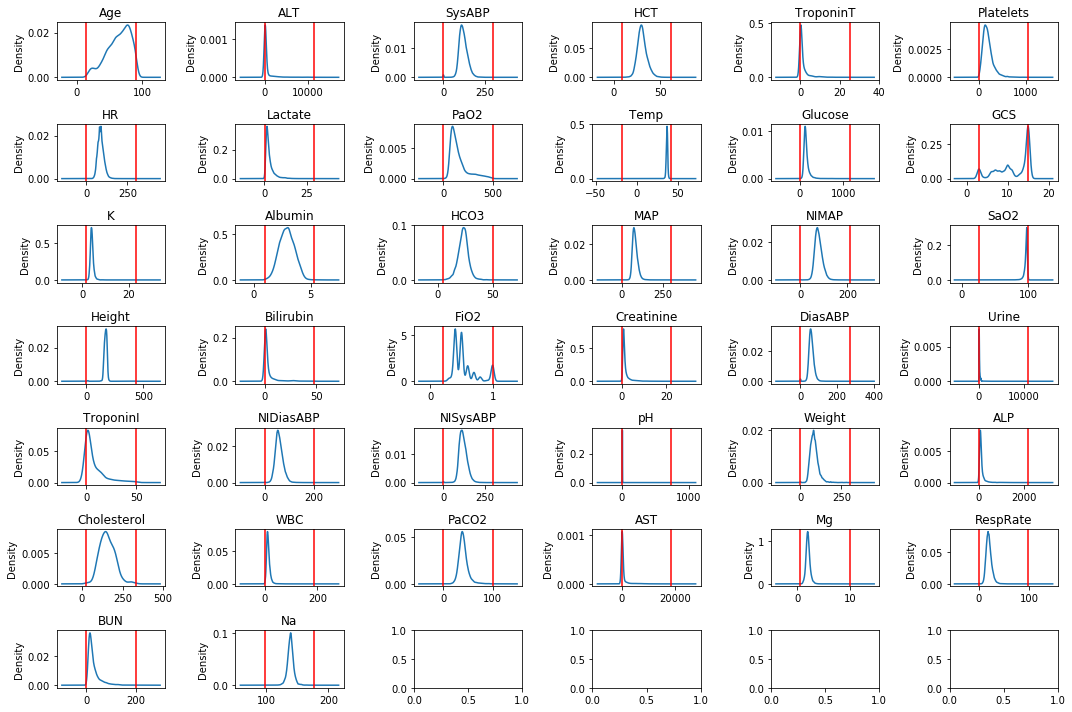

In [281]:
fig, ax = plt.subplots(nrows=7, ncols=6, figsize=(15,10))

# fig.suptitle('Univariate KDE of standardizable variables')

for index, var in enumerate(standardizable_vars):
    
    num_col = index % 6
    num_row = int(index / 6)

    axis = ax[num_row, num_col]
    axis.set_title(var)
    values = seta_data[seta_data['Parameter'] == var]['Value']
    
    values.plot.kde(ax=axis)
    
    axis.axvline(x=values.min(),color='r', label='min')
    axis.axvline(x=values.max(),color='r', label='max')
#     plt.legend(loc='upper right')
plt.tight_layout()

After I plotted the KDEs of variables, some things came to mind. 

1. Some variables really do have outliers. For example, see Temp, which is generally around the 36 - 37 range. I would guess that this is in Celsius. However, the min value is -17.8 (about 0 degrees F). The most compatible story with that data point is measurement error of some sort, unless the individual came from a really cold place initially...

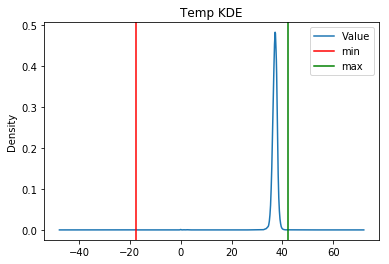

In [277]:
fig, ax = plt.subplots(1,1)
values = seta_data[seta_data['Parameter'] == 'Temp']['Value']
values.plot.kde(title='Temp KDE', ax=ax)
ax.axvline(x=values.min(),color='r', label='min')
ax.axvline(x=values.max(),color='r', label='max')
plt.legend(loc='upper right')

In [280]:
seta_data[seta_data['Parameter'] == 'Troponini'].describe()

,PATIENT_ID,Value
count,0.0,0.0
mean,NaN,NaN
std,NaN,NaN
min,NaN,NaN
25%,NaN,NaN
50%,NaN,NaN
75%,NaN,NaN
max,NaN,NaN


In [261]:
seta_data[seta_data['Parameter'] == 'Glucose'].describe()

,PATIENT_ID,Value
count,13021.000000,13021.000000
mean,137549.376546,141.509561
std,2927.082519,67.697572
min,132539.000000,10.000000
25%,135006.000000,105.000000
50%,137489.000000,127.000000
75%,140065.000000,157.000000
max,142673.000000,1143.000000


In [262]:
seta_data[seta_data['Parameter'] == 'Temp'].describe()

,PATIENT_ID,Value
count,86405.000000,86405.000000
mean,137626.043956,37.007651
std,2899.986755,1.775174
min,132539.000000,-17.800000
25%,135103.000000,36.600000
50%,137699.000000,37.100000
75%,140077.000000,37.600000
max,142673.000000,42.100000


### Remove Measurement Outliers

As we can see from above, some readings are highly suspect and are basically impossible for people. For example, we know _a priori_ that pH scales up to 14. A value of 1000 is non-sensical.

This is tricky. On one hand, outliers might be useful in that the nature of being far away from the center could be predictive of the outcome. On the other hand, extreme outliers could be due to measurement and are thus not indicative of the true values that the patient has. If I had more time, I'd look into what are more sensible bounds for each. However, since I didn't really have a lot of time to do this project, I'm going to use a heuristic. I'm gonna take the interquartile range. Anything above that is 2 times IQR over the 75-th percentile and anything below 2 times IQR under 25-th percentile is going to be assumed as most likely due to measurement error. I chose 2 arbitrarily; I didn't want to set it too low because values underneath might not actually be measurement error -- just regular values for a person. Setting the cutoff to more extreme values makes it more likely that the "outliers" I find could just be measurement mistakes.

In [351]:
seta_data[seta_data['Parameter'] == 'ALT']

,PATIENT_ID,Parameter,Time,Value
828,132541,ALT,01:36,91.0
953,132541,ALT,14:21,75.0
1243,132543,ALT,00:11,12.0
1999,132547,ALT,03:38,45.0
2150,132547,ALT,23:11,60.0
2830,132551,ALT,00:50,46.0
4280,132556,ALT,02:59,36.0
5535,132570,ALT,05:27,15.0
7693,132584,ALT,01:14,10.0
7821,132584,ALT,10:14,10.0


In [347]:
variables = {}

for var in standardizable_vars:

    variables[var] = {
        'data': seta_data[seta_data['Parameter'] == var].copy()
    }

    variables[var]['describe'] = variables[var]['data']['Value'].describe()

    variables[var]['IQR'] = variables[var]['describe']['75%'] - variables[var]['describe']['25%']


    mask = (
            variables[var]['data']['Value'] > variables[var]['describe']['75%'] + 2 * variables[var]['IQR']
        ) | \
        (
            variables[var]['data']['Value'] < variables[var]['describe']['25%'] - 2 * variables[var]['IQR']
        )

    variables[var]['data']['remove_outlier_values'] = variables[var]['data']['Value'].copy()
    
    
    # replace any really unlikely values with nan. We'll standardize later
    variables[var]['data'].loc[mask, 'remove_outlier_values'] = np.nan

In [353]:
variables['ALT']['data'].tail(5)

,PATIENT_ID,Parameter,Time,Value,remove_outlier_values
1756796,142671,ALT,00:22,2364.0,NaN
1756863,142671,ALT,06:52,2036.0,NaN
1757030,142671,ALT,28:22,1513.0,NaN
1757721,142673,ALT,29:59,28.0,28.0
1757884,142673,ALT,41:51,9.0,9.0


In [177]:
mean = seta_data.groupby((seta_data.index, 'Parameter')).mean()
mean

/Users/eddericugaddan/miniconda3/envs/icu-survival/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


,,PATIENT_ID,Value
,Parameter,,
0,RecordID,132539,132539.00
1,Age,132539,54.00
2,Gender,132539,0.00
3,Height,132539,NaN
4,ICUType,132539,4.00
5,Weight,132539,NaN
6,GCS,132539,15.00
7,HR,132539,73.00
8,NIDiasABP,132539,65.00


In [180]:
mean_reset = mean.reset_index()[['Parameter', 'PATIENT_ID', 'Value']]
mean_reset

,Parameter,PATIENT_ID,Value
0,RecordID,132539,132539.00
1,Age,132539,54.00
2,Gender,132539,0.00
3,Height,132539,NaN
4,ICUType,132539,4.00
5,Weight,132539,NaN
6,GCS,132539,15.00
7,HR,132539,73.00
8,NIDiasABP,132539,65.00
9,NIMAP,132539,92.33


In [160]:
unique_parameters

array(['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight', 'GCS',
       'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'RespRate', 'Temp',
       'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg',
       'Platelets', 'K', 'Na', 'WBC', 'pH', 'PaCO2', 'PaO2', 'DiasABP',
       'FiO2', 'MAP', 'MechVent', 'SysABP', 'SaO2', 'Albumin', 'ALP',
       'ALT', 'AST', 'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI',
       'TroponinT'], dtype=object)

In [161]:
def get_series(data, parameter, prefix, patient_id_column='PATIENT_ID'):
    """
        Returns a dataframe where the only column is the parameter. 
        Indexed by patient_id_column.
        
        Parameters:
            data: pandas.df
            
            parameter: string.
                name of the parameter (e.g. Age)
            
            patient_id_column: string. (Optional)
                the name of the column that identifies the patient
    """
    
    df = data[data['Parameter'] == parameter]
    grouped = df.groupby(patient_id_column).sum()
    grouped.columns = [prefix + parameter]
    
    return grouped

In [192]:
def generate_aggregated_table(data, parameters, prefix, patient_id_column='PATIENT_ID'):
    """
        Produces a dataframe where columns are of aggregated quantities
        
        parameters:
            data: pandas.DataFrame
                Contains a patient id column (indicated by patient_id_column parameter),
                a Parameter column, and a Value column
                
            parameters: array of strings
                Contains the names of the parameters
                
            prefix: string
                The prefix to prepend to the column names. Used to indicate what type
                of aggregation there is (e.g. 'mean', 'var')
                
            patient_id_column: string (Optional)
                The name of the column that stands for the patient ID.
                Defaults to 'PATIENT_ID'
                
        returns: pandas.DataFrame
            Columns are of aggregated quantities
            
    """
    
    collection_df = get_series(data, parameters[0], prefix=prefix)
    
    for i in range(1, len(parameters)):
        
        collection_df = pd.merge(
            left=collection_df,
            right=get_series(data, parameters[i], prefix=prefix),
            how='left',
            on=patient_id_column
        )
        
    return pd.DataFrame(collection_df)

In [231]:
pd.concat([mean_data, pd.get_dummies(mean_data['meanICUType'], prefix='ICUType')], axis=1)

,meanRecordID,meanAge,meanGender,meanHeight,meanICUType,meanWeight,meanGCS,meanHR,meanNIDiasABP,meanNIMAP,...,meanAST,meanBilirubin,meanLactate,meanCholesterol,meanTroponinI,meanTroponinT,ICUType_1.0,ICUType_2.0,ICUType_3.0,ICUType_4.0
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
132539,132539.0,54.0,0.0,0.0,4.0,0.0,194.0,2620.0,1705.0,2433.01,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,1
132540,132540.0,76.0,1.0,175.3,2.0,2742.8,200.0,5494.0,794.0,1054.32,...,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,0
132541,132541.0,44.0,0.0,0.0,3.0,3118.5,77.0,4523.0,3002.0,3676.55,...,399.0,5.8,4.1,NaN,NaN,NaN,0,0,1,0
132543,132543.0,68.0,1.0,180.3,3.0,5076.0,269.0,4259.0,3773.0,4865.36,...,15.0,0.2,NaN,NaN,NaN,NaN,0,0,1,0
132545,132545.0,88.0,0.0,0.0,3.0,0.0,180.0,3598.0,1966.0,3222.70,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0
132547,132547.0,64.0,1.0,180.3,1.0,114.0,130.0,4161.0,141.0,163.97,...,209.0,0.4,NaN,212.0,1.3,NaN,1,0,0,0
132548,132548.0,68.0,0.0,162.6,3.0,5133.0,180.0,4032.0,504.0,715.03,...,NaN,NaN,NaN,NaN,1.5,NaN,0,0,1,0
132551,132551.0,78.0,0.0,162.6,3.0,3388.0,154.0,5179.0,1320.0,2372.65,...,82.0,0.3,13.1,NaN,6.6,NaN,0,0,1,0
132554,132554.0,64.0,0.0,0.0,3.0,2852.9,210.0,5853.0,2966.0,3885.96,...,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0


In [199]:
mean_data = generate_aggregated_table(mean_reset, parameters=unique_parameters, prefix='mean')
mean_data

,meanRecordID,meanAge,meanGender,meanHeight,meanICUType,meanWeight,meanGCS,meanHR,meanNIDiasABP,meanNIMAP,...,meanSaO2,meanAlbumin,meanALP,meanALT,meanAST,meanBilirubin,meanLactate,meanCholesterol,meanTroponinI,meanTroponinT
PATIENT_ID,,,,,,,,,,,,,,,,,,,,,
132539,132539.0,54.0,0.0,0.0,4.0,0.0,194.0,2620.0,1705.0,2433.01,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132540,132540.0,76.0,1.0,175.3,2.0,2742.8,200.0,5494.0,794.0,1054.32,...,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132541,132541.0,44.0,0.0,0.0,3.0,3118.5,77.0,4523.0,3002.0,3676.55,...,95.0,5.0,232.0,166.0,399.0,5.8,4.1,NaN,NaN,NaN
132543,132543.0,68.0,1.0,180.3,3.0,5076.0,269.0,4259.0,3773.0,4865.36,...,NaN,4.4,105.0,12.0,15.0,0.2,NaN,NaN,NaN,NaN
132545,132545.0,88.0,0.0,0.0,3.0,0.0,180.0,3598.0,1966.0,3222.70,...,NaN,3.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
132547,132547.0,64.0,1.0,180.3,1.0,114.0,130.0,4161.0,141.0,163.97,...,485.0,NaN,101.0,105.0,209.0,0.4,NaN,212.0,1.3,NaN
132548,132548.0,68.0,0.0,162.6,3.0,5133.0,180.0,4032.0,504.0,715.03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.5,NaN
132551,132551.0,78.0,0.0,162.6,3.0,3388.0,154.0,5179.0,1320.0,2372.65,...,482.0,1.9,47.0,46.0,82.0,0.3,13.1,NaN,6.6,NaN
132554,132554.0,64.0,0.0,0.0,3.0,2852.9,210.0,5853.0,2966.0,3885.96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [200]:
mean_data.columns

Index(['meanRecordID', 'meanAge', 'meanGender', 'meanHeight', 'meanICUType',
       'meanWeight', 'meanGCS', 'meanHR', 'meanNIDiasABP', 'meanNIMAP',
       'meanNISysABP', 'meanRespRate', 'meanTemp', 'meanUrine', 'meanHCT',
       'meanBUN', 'meanCreatinine', 'meanGlucose', 'meanHCO3', 'meanMg',
       'meanPlatelets', 'meanK', 'meanNa', 'meanWBC', 'meanpH', 'meanPaCO2',
       'meanPaO2', 'meanDiasABP', 'meanFiO2', 'meanMAP', 'meanMechVent',
       'meanSysABP', 'meanSaO2', 'meanAlbumin', 'meanALP', 'meanALT',
       'meanAST', 'meanBilirubin', 'meanLactate', 'meanCholesterol',
       'meanTroponinI', 'meanTroponinT'],
      dtype='object')

In [201]:
mean_with_outcomes = pd.merge(left=mean_data, right=outcomes, left_on='PATIENT_ID', right_on='RecordID')

The means of predictors individually are not strong predictors of the outcome.

In [213]:
mean_with_outcomes['meanSysABP'].mean()

6176.61629153269

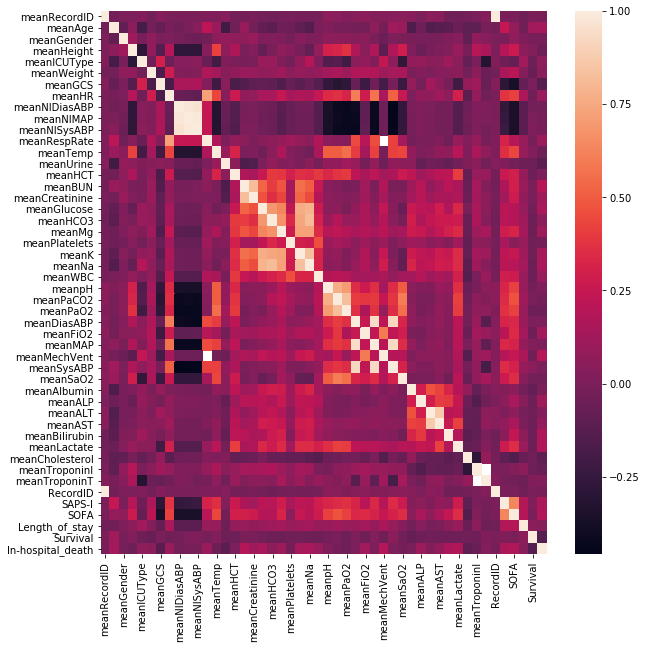

In [203]:
plt.figure(figsize=(10,10))
sns.heatmap(mean_with_outcomes.corr())

In [212]:
mean_with_outcomes['meanSysABP'].describe()

count     2799.000000
mean      6176.616292
std       2561.940659
min          0.000000
25%       4684.000000
50%       6272.000000
75%       7690.000000
max      17507.000000
Name: meanSysABP, dtype: float64

In [215]:
mean_with_outcomes['In-hospital_death']

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       1
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      1
21      0
22      0
23      0
24      0
25      0
26      1
27      0
28      0
29      1
       ..
3970    0
3971    0
3972    0
3973    1
3974    0
3975    0
3976    0
3977    1
3978    0
3979    1
3980    0
3981    0
3982    0
3983    1
3984    0
3985    0
3986    0
3987    0
3988    0
3989    0
3990    0
3991    0
3992    0
3993    0
3994    0
3995    0
3996    0
3997    0
3998    1
3999    0
Name: In-hospital_death, Length: 4000, dtype: int64

In [218]:
variables = {}
variables['meanSysABP'] = {
    'data': np.copy(mean_with_outcomes['meanSysABP'].values)
}
variables['meanSysABP']['mask'] = np.isfinite(variables['meanSysABP']['data'])
variables['meanSysABP']['data'][
    ~variables['meanSysABP']['mask']
] = -999

variables['meanSysABP']['masked'] = np.ma.masked_values(variables['meanSysABP']['data'], value=-999)

In [219]:
variables['meanSysABP']['masked']

masked_array(data=[--, 7712.0, 2011.0, ..., 754.0, 8664.0, 10261.0],
             mask=[ True, False, False, ..., False, False, False],
       fill_value=-999.0)

In [220]:
variables['meanSysABP']['data'].mean(), variables['meanSysABP']['data'].std()

(4022.1375, 3925.446527478594)

In [221]:
with pm.Model() as simple:
    betas = pm.Normal('betas', mu=0, sd=2)
    alpha = pm.Normal('alpha', mu=0, sd=2)
    sysABP = pm.Normal('sysABP', mu=4000, sd=4000, observed=variables['meanSysABP']['masked'])
    
    summation = betas * sysABP
    
    pm.Bernoulli('observed', p=pm.math.sigmoid(summation), observed=mean_with_outcomes['In-hospital_death'])
    
    simple_traces = pm.sample()

/Users/eddericugaddan/miniconda3/envs/icu-survival/lib/python3.7/site-packages/pymc3/model.py:1266: UserWarning: Data in sysABP contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sysABP_missing, alpha, betas]
Sampling 4 chains: 100%|██████████| 4000/4000 [01:18<00:00, 50.78draws/s] 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14c4e9e48>,
      dtype=object)

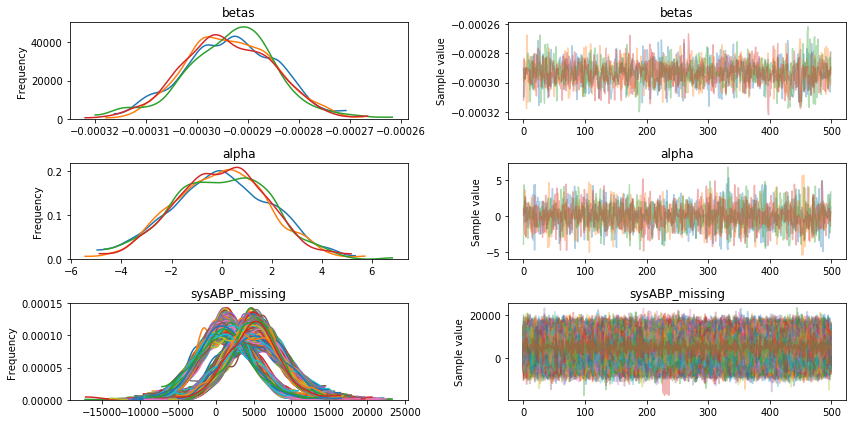

In [222]:
pm.traceplot(simple_traces)

In [ ]:
neocortex = np.copy(d['neocortex.prop'].values)
mask = np.isfinite(neocortex)
kcal = np.copy(d['kcal.per.g'].values[mask])
logmass = np.copy(d['logmass'].values[mask])
neocortex = neocortex[mask]

# fit model
with pm.Model() as m_14_3cc:
    sigma = pm.HalfCauchy('sigma', 1.)
    bN = pm.Normal('bN', 0., 10.)
    bM = pm.Normal('bM', 0., 10.)
    a = pm.Normal('a', 0., 100.)
    mu = a + bN*neocortex + bM*logmass
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    trace_14_3cc = pm.sample(5000, tune=5000, njobs=2)

pm.summary(trace_14_3cc, varnames=['a', 'bN', 'bM', 'sigma']).round(2)

In [ ]:
params_to_plot = params_without_record_id
fig, ax = plt.subplots(len(params_to_plot),2, figsize=(20,len(params_to_plot) * 3))


for index, param in enumerate(params_to_plot):
    survive_axis = ax[index, 0]
    plot(parameter=param, data=survivor_data, ax=survive_axis)
#     survive_axis.set_xlim(0,100)
    survive_axis.set_title('Survived: ' + param)
    
    die_axis = ax[index, 1]
    plot(parameter=param, data=dead_data, ax=die_axis)
#     die_axis.set_xlim(0,100)
    die_axis.set_title('Died: ' + param)

plt.tight_layout()


/Users/eddericugaddan/miniconda3/envs/icu-survival/lib/python3.7/site-packages/pandas/plotting/_core.py:998: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0.0, right=0.0
  ax.set_xlim(left, right)


KeyboardInterrupt: 

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.


In [26]:
pd.merge(left=seta_data, right=outcomes, left_on='PATIENT_ID', right_on='RecordID')

,PATIENT_ID,Parameter,Time,Value,RecordID,SAPS-I,SOFA,Length_of_stay,Survival,In-hospital_death
0,132539,RecordID,00:00,132539.00,132539,6,1,5,-1,0
1,132539,Age,00:00,54.00,132539,6,1,5,-1,0
2,132539,Gender,00:00,0.00,132539,6,1,5,-1,0
3,132539,Height,00:00,-1.00,132539,6,1,5,-1,0
4,132539,ICUType,00:00,4.00,132539,6,1,5,-1,0
5,132539,Weight,00:00,-1.00,132539,6,1,5,-1,0
6,132539,GCS,00:07,15.00,132539,6,1,5,-1,0
7,132539,HR,00:07,73.00,132539,6,1,5,-1,0
8,132539,NIDiasABP,00:07,65.00,132539,6,1,5,-1,0
9,132539,NIMAP,00:07,92.33,132539,6,1,5,-1,0


In [7]:
seta_data['Parameter'].unique()

array(['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight', 'GCS',
       'HR', 'NIDiasABP', 'NIMAP', 'NISysABP', 'RespRate', 'Temp',
       'Urine', 'HCT', 'BUN', 'Creatinine', 'Glucose', 'HCO3', 'Mg',
       'Platelets', 'K', 'Na', 'WBC', 'pH', 'PaCO2', 'PaO2', 'DiasABP',
       'FiO2', 'MAP', 'MechVent', 'SysABP', 'SaO2', 'Albumin', 'ALP',
       'ALT', 'AST', 'Bilirubin', 'Lactate', 'Cholesterol', 'TroponinI',
       'TroponinT'], dtype=object)